In [1]:
# !pip install pennylane koreanize_matplotlib -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import koreanize_matplotlib
from IPython.display import clear_output
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
n_layers = 3
epochs   = 300
lr       = 0.01
# ===== 수정 끝 =====
# ============================================================

# --- 공통 데이터 ---
x1 = std_np.array([2*i + 1   for i in range(50)], dtype=float)
x2 = std_np.array([2*(i + 1) for i in range(50)], dtype=float)
y  = x1 * x2
THEORY_SUM = 169150

def scale_x(x):      return (x - 1) / 99 * std_np.pi
Y_MIN, Y_MAX = 2.0, 9900.0
def scale_y(y_val):  return (y_val - Y_MIN) / (Y_MAX - Y_MIN)
def unscale_y(y_sc): return y_sc * (Y_MAX - Y_MIN) + Y_MIN

x1_sc = scale_x(x1)
x2_sc = scale_x(x2)
y_sc  = scale_y(y)

std_np.random.seed(42)
idx       = std_np.random.permutation(50)
n_train   = 35
idx_train = idx[:n_train]
idx_test  = idx[n_train:]

print("=" * 60)
print("lab8: MLP  vs  RY+CNOT  vs  IQP+SEL  최종 비교")
print("=" * 60)
print(f"  n_layers={n_layers}, epochs={epochs}, lr={lr}")

dev = qml.device("default.qubit", wires=2)

lab8: MLP  vs  RY+CNOT  vs  IQP+SEL  최종 비교
  n_layers=3, epochs=300, lr=0.01


In [2]:
# ===========================================================
#  모델 정의
# ===========================================================

# --- MLP (Lab 5) ---
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 3), nn.Tanh(),
            nn.Linear(3, 1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).squeeze()

# --- VQR RY+CNOT (Lab 6) ---
@qml.qnode(dev)
def vqr_basic(inputs, weights):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.CNOT(wires=[0, 1])
    for l in range(n_layers):
        qml.RY(weights[l, 0], wires=0)
        qml.RY(weights[l, 1], wires=1)
        qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# --- VQR IQP+SEL (Lab 7) ---
@qml.qnode(dev)
def vqr_iqp(inputs, weights):
    qml.IQPEmbedding(inputs, wires=[0, 1], n_repeats=1)
    qml.StronglyEntanglingLayers(weights, wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# 파라미터 수
n_params_mlp   = sum(p.numel() for p in MLP().parameters())
n_params_basic = n_layers * 2
w_shape_sel    = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=2)
n_params_iqp   = int(std_np.prod(w_shape_sel))

print(f"\n  {'모델':>15s}  {'파라미터':>8s}")
print("  " + "-" * 28)
print(f"  {'MLP':>15s}  {n_params_mlp:8d}")
print(f"  {'RY+CNOT':>15s}  {n_params_basic:8d}")
print(f"  {'IQP+SEL':>15s}  {n_params_iqp:8d}")

# ===========================================================
#  공통 양자 학습 함수
# ===========================================================
def qml_cost(circuit, weights):
    total = np.array(0.0)
    for i in idx_train:
        inp  = np.array([x1_sc[i], x2_sc[i]])
        pred = (circuit(inp, weights) + 1) / 2
        total = total + (pred - y_sc[i]) ** 2
    return total / n_train

def qml_predict(circuit, weights):
    preds = []
    for i in range(50):
        inp  = np.array([x1_sc[i], x2_sc[i]])
        p_sc = (float(circuit(inp, weights)) + 1) / 2
        preds.append(unscale_y(p_sc))
    return std_np.array(preds)

def qml_train(circuit, weights, label):
    opt     = qml.AdamOptimizer(stepsize=lr)
    history = []
    for ep in range(epochs):
        weights = opt.step(lambda w: qml_cost(circuit, w), weights)
        loss    = float(qml_cost(circuit, weights))
        history.append(loss)
        if ep % 10 == 0 or ep == epochs - 1:
            clear_output(wait=True)
            preds_now = qml_predict(circuit, weights)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            fig.suptitle(f"lab8 [{label}] 훈련 중... epoch {ep+1}/{epochs}", fontsize=12)
            ax1.plot(history, 'b-', lw=2)
            ax1.set_xlabel("Epoch"); ax1.set_ylabel("MSE (scaled)")
            ax1.set_title("학습 곡선"); ax1.set_xlim(0, epochs); ax1.grid(True, alpha=0.3)
            ax2.scatter(y[idx_train], preds_now[idx_train], c='steelblue', alpha=0.6, s=30, label='train')
            ax2.scatter(y[idx_test],  preds_now[idx_test],  c='tomato',    alpha=0.8, s=50, label='test')
            ax2.plot([0, 10500], [0, 10500], 'k--', lw=1, label='완벽 예측선')
            ax2.set_xlabel("실제 y"); ax2.set_ylabel("예측 y")
            ax2.set_title(f"예측 vs 실제  (총합={preds_now.sum():.0f})")
            ax2.legend(); ax2.grid(True, alpha=0.3)
            plt.tight_layout(); plt.show()
    return weights, history


               모델      파라미터
  ----------------------------
              MLP        13
          RY+CNOT         6
          IQP+SEL        18


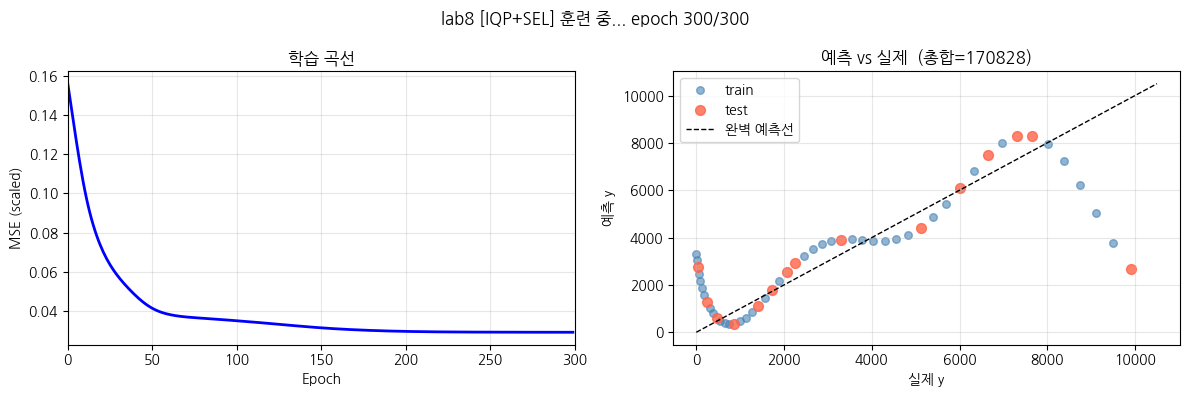


최종 비교 결과
               모델      파라미터          총합          오차      test MSE
  --------------------------------------------------------------
               이론       ---    169150.0         0.0           ---
              MLP        13    169259.5       109.5     282953.32
          RY+CNOT         6    171914.7      2764.7      60951.74
          IQP+SEL        18    170828.3      1678.3    4314804.29


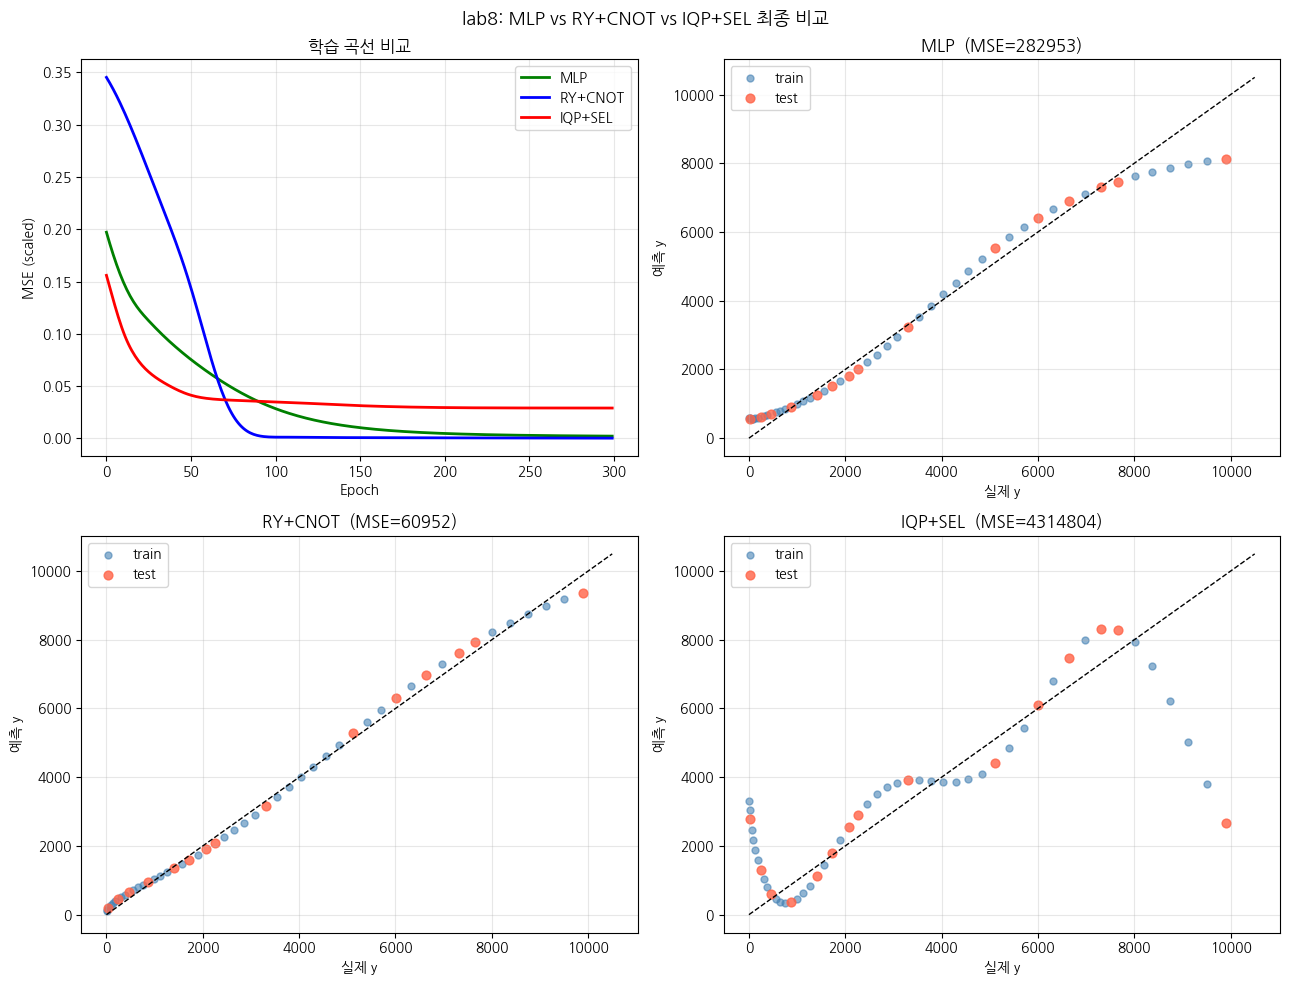


lab8 완료!


In [3]:
# ===========================================================
#  학습 실행
# ===========================================================

# --- MLP 학습 ---
print("\n[1/3] MLP 학습 중...")
X_train_t = torch.tensor(std_np.column_stack([x1_sc[idx_train], x2_sc[idx_train]]),
                          dtype=torch.float32)
y_train_t = torch.tensor(y_sc[idx_train], dtype=torch.float32)
X_all_t   = torch.tensor(std_np.column_stack([x1_sc, x2_sc]), dtype=torch.float32)

torch.manual_seed(42)
mlp       = MLP()
opt_mlp   = torch.optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.MSELoss()
hist_mlp  = []

for ep in range(epochs):
    opt_mlp.zero_grad()
    pred = mlp(X_train_t)
    loss = criterion(pred, y_train_t)
    loss.backward(); opt_mlp.step()
    hist_mlp.append(loss.item())
    '''
    if ep % 10 == 0 or ep == epochs - 1:
        clear_output(wait=True)
        with torch.no_grad():
            preds_now = mlp(X_all_t).numpy() * (Y_MAX - Y_MIN) + Y_MIN
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"lab8 [MLP] 훈련 중... epoch {ep+1}/{epochs}", fontsize=12)
        ax1.plot(hist_mlp, 'b-', lw=2)
        ax1.set_xlabel("Epoch"); ax1.set_ylabel("MSE (scaled)")
        ax1.set_title("학습 곡선"); ax1.set_xlim(0, epochs); ax1.grid(True, alpha=0.3)
        ax2.scatter(y[idx_train], preds_now[idx_train], c='steelblue', alpha=0.6, s=30, label='train')
        ax2.scatter(y[idx_test],  preds_now[idx_test],  c='tomato',    alpha=0.8, s=50, label='test')
        ax2.plot([0, 10500], [0, 10500], 'k--', lw=1, label='완벽 예측선')
        ax2.set_xlabel("실제 y"); ax2.set_ylabel("예측 y")
        ax2.set_title(f"예측 vs 실제  (총합={preds_now.sum():.0f})")
        ax2.legend(); ax2.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()
        '''

with torch.no_grad():
    mlp_preds = mlp(X_all_t).numpy() * (Y_MAX - Y_MIN) + Y_MIN

# --- RY+CNOT 학습 ---
print("\n[2/3] RY+CNOT 학습 중...")
std_np.random.seed(42)
w_basic        = np.array(std_np.random.uniform(0, std_np.pi, (n_layers, 2)), requires_grad=True)
w_basic, hist_basic = qml_train(vqr_basic, w_basic, "RY+CNOT")
preds_basic    = qml_predict(vqr_basic, w_basic)

# --- IQP+SEL 학습 ---
print("\n[3/3] IQP+SEL 학습 중...")
std_np.random.seed(42)
w_iqp          = np.array(std_np.random.uniform(0, std_np.pi, w_shape_sel), requires_grad=True)
w_iqp, hist_iqp = qml_train(vqr_iqp, w_iqp, "IQP+SEL")
preds_iqp      = qml_predict(vqr_iqp, w_iqp)

# ===========================================================
#  최종 비교
# ===========================================================
sum_mlp    = mlp_preds.sum()
sum_basic  = preds_basic.sum()
sum_iqp    = preds_iqp.sum()
mse_mlp    = std_np.mean((mlp_preds[idx_test]  - y[idx_test]) ** 2)
mse_basic  = std_np.mean((preds_basic[idx_test] - y[idx_test]) ** 2)
mse_iqp    = std_np.mean((preds_iqp[idx_test]   - y[idx_test]) ** 2)

print("\n" + "=" * 65)
print("최종 비교 결과")
print("=" * 65)
print(f"  {'모델':>15s}  {'파라미터':>8s}  {'총합':>10s}  {'오차':>10s}  {'test MSE':>12s}")
print("  " + "-" * 62)
print(f"  {'이론':>15s}  {'---':>8s}  {THEORY_SUM:10.1f}  {0:10.1f}  {'---':>12s}")
print(f"  {'MLP':>15s}  {n_params_mlp:8d}  {sum_mlp:10.1f}  {abs(sum_mlp-THEORY_SUM):10.1f}  {mse_mlp:12.2f}")
print(f"  {'RY+CNOT':>15s}  {n_params_basic:8d}  {sum_basic:10.1f}  {abs(sum_basic-THEORY_SUM):10.1f}  {mse_basic:12.2f}")
print(f"  {'IQP+SEL':>15s}  {n_params_iqp:8d}  {sum_iqp:10.1f}  {abs(sum_iqp-THEORY_SUM):10.1f}  {mse_iqp:12.2f}")

# 비교 시각화
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
fig.suptitle("lab8: MLP vs RY+CNOT vs IQP+SEL 최종 비교", fontsize=13)

# 학습 곡선
axes[0, 0].plot(hist_mlp,   'g-',  lw=2, label='MLP')
axes[0, 0].plot(hist_basic, 'b-',  lw=2, label='RY+CNOT')
axes[0, 0].plot(hist_iqp,   'r-',  lw=2, label='IQP+SEL')
axes[0, 0].set_xlabel("Epoch"); axes[0, 0].set_ylabel("MSE (scaled)")
axes[0, 0].set_title("학습 곡선 비교")
axes[0, 0].legend(); axes[0, 0].grid(True, alpha=0.3)

# 예측 vs 실제 3개
for ax, preds, label, mse, color in [
    (axes[0, 1], mlp_preds,   f"MLP  (MSE={mse_mlp:.0f})",        mse_mlp,   'green'),
    (axes[1, 0], preds_basic, f"RY+CNOT  (MSE={mse_basic:.0f})",  mse_basic, 'steelblue'),
    (axes[1, 1], preds_iqp,   f"IQP+SEL  (MSE={mse_iqp:.0f})",   mse_iqp,   'tomato'),
]:
    ax.scatter(y[idx_train], preds[idx_train], c='steelblue', alpha=0.6, s=25, label='train')
    ax.scatter(y[idx_test],  preds[idx_test],  c='tomato',    alpha=0.8, s=40, label='test')
    ax.plot([0, 10500], [0, 10500], 'k--', lw=1)
    ax.set_xlabel("실제 y"); ax.set_ylabel("예측 y")
    ax.set_title(label); ax.legend(); ax.grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

print("\nlab8 완료!")